# We finally try training all of the 4803 characters

In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import PIL.Image
from matplotlib import pyplot as plt

from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = ['Heiti TC'] 
plt.rcParams['axes.unicode_minus'] = False  # in case minus sign is shown as box

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  
from tensorflow.keras.optimizers import Adam

### Specify relevant raw, training, and testing data route

In [4]:
raw_data_path = '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_characters_cleaned'
training_data_path = '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data/'
testing_data_path = '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_testing_data/'

os.chdir(raw_data_path)
print( 'Current working directory:', os.getcwd() ) 

Current working directory: /Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_characters_cleaned


### Get the entire dataset from raw dataset

In [5]:
complete_chars = os.listdir(os.getcwd())
complete_chars.remove('.DS_Store')

### We create our training directories from the raw dataset

In [6]:
os.chdir(raw_data_path)
try: 
    os.mkdir(training_data_path) 

except:
    shutil.rmtree(training_data_path)
    os.mkdir(training_data_path) 

finally: 
    for char in complete_chars:
        shutil.copytree(raw_data_path+'/'+char, training_data_path+'/'+char )

In [8]:
os.getcwd()

'/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_characters_cleaned'

### Let's visualize a sample data

In [24]:
img_list = []
for char in complete_chars : 
    folder_path = training_data_path+'/'+char
    file_names = os.listdir(folder_path)
    for i in range(7):
        img_list.append(folder_path+'/'+file_names[i])

In [25]:
img_list[:3]

['/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data//理/理_21.png',
 '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data//理/理_35.png',
 '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data//理/理_34.png']

### Sample Data

2022-06-11 23:06:54.207769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


{'歟', '理', '詼', '竊'}


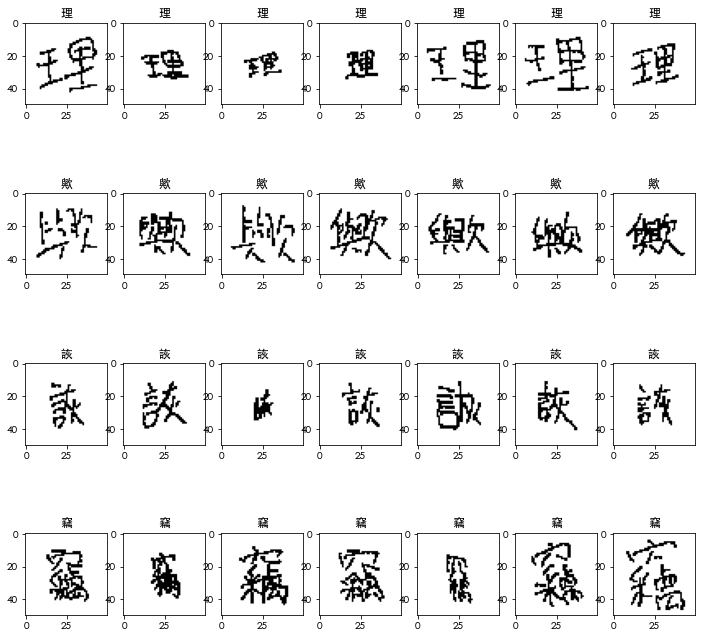

In [26]:
l = []
for i in range(28):      
    plt.subplot(4,7,i+1)
    title = img_list[i].split('/')[-1].split('_')[0]
    
    plt.gcf().set_size_inches((12,12)) 
    img = load_img(img_list[i])  
    img = tf.constant(np.array(img))
    plt.imshow(img)
    plt.title(title)
    l.append(title)
print(set(l))

----

### Data Augmentation

#### Training Set

In [6]:
train_data_gen = ImageDataGenerator(rescale = 1./255, 
                                    validation_split = 0.2,
                                    width_shift_range = 0.05,   
                                    height_shift_range = 0.05,
                                    zoom_range = 0.1)

In [7]:
train_gen = train_data_gen.flow_from_directory(training_data_path,
                                               target_size = (50,50),
                                               batch_size = 8,
                                               class_mode = 'categorical',
                                               subset = 'training')

Found 202069 images belonging to 4803 classes.


#### Testing Set

In [8]:
test_data_gen = ImageDataGenerator(rescale = 1./255, 
                                    validation_split = 0.2)

In [9]:
test_gen = test_data_gen.flow_from_directory(training_data_path,
                                             target_size = (50,50),
                                             batch_size = 8,
                                             class_mode = 'categorical',
                                             subset = 'validation')

Found 48643 images belonging to 4803 classes.


In [10]:
test_gen[0][0].shape

(8, 50, 50, 3)

### Construct the CNN Sequential Model

In [11]:
model = Sequential() 
model.add(
    Conv2D(filters=5, 
           kernel_size=(2,2), 
           activation='relu', 
           padding='same',
           input_shape=(50,50,3),
          )
)

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(
     Conv2D(filters=5, 
            kernel_size=(2,2), 
            activation='relu', 
            padding='same',
           )
)

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(rate=0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(len(complete_chars), activation='softmax'))


2022-06-11 23:28:53.519672: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 5)         65        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 5)         105       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 720)               0         
_________________________________________________________________
dropout (Dropout)            (None, 720)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

### Compile the model

In [13]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

---

### Fit and train the model 
#### (Note: this is done with the same-named python script in this directory to avoid Jupyter kernel death)

In [ ]:
history = model.fit(train_gen, validation_data=test_gen, epochs=50)

#### We see from the result after 50 epochs that it only acheives a 20% accuracy rate on the test set. 
#### More epochs may help, but this is due to the inherent nature of limited data we have.

---

### Save the model

In [82]:
os.chdir(training_data_path)
model.save('CNN_model_complete.h5')

### Save the history info to track accuracy and loss

In [ ]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)